In [11]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [13]:
NEG_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/negative'
POS_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/positive'
ANC_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/anchor'

In [14]:
# Negative dataset : https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
for directory in os.listdir('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [15]:
# Random but unique name for img
import uuid

In [6]:
# Use camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #250x250 pixel
    frame = frame[ 200:200+250, 170:170+250, :]
    
    #Collect anchor
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positive
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        

    #Show image
    cv2.imshow('IMAGE', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH +'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH +'/*.jpg').take(500)

In [17]:
img_test = anchor.as_numpy_iterator()
print(img_test.next())

b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/3ef06352-7413-11ef-98b8-e81f155e7428.jpg'


In [18]:
def preprocess(file_path):
    read_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(read_img)

    img = tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [19]:
img = preprocess('/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/46e33417-7413-11ef-855e-e81f155e7428.jpg')

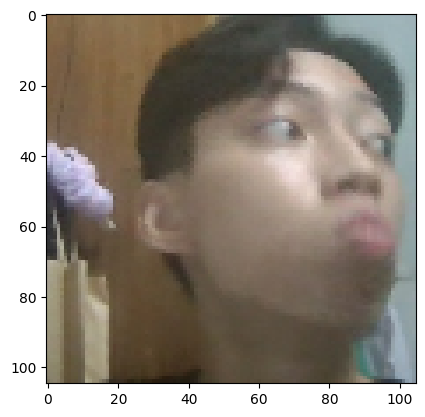

In [20]:
plt.imshow(img)

In [21]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
try_img = data.as_numpy_iterator()
try_img = try_img.next()
try_img

(b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/4cdf6373-7413-11ef-8ea0-e81f155e7428.jpg',
 b'/home/leloc/Documents/USTH-B3/Group_project/Model/positive/b9882d04-7413-11ef-816b-e81f155e7428.jpg',
 np.float32(1.0))

In [24]:
def double_check(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


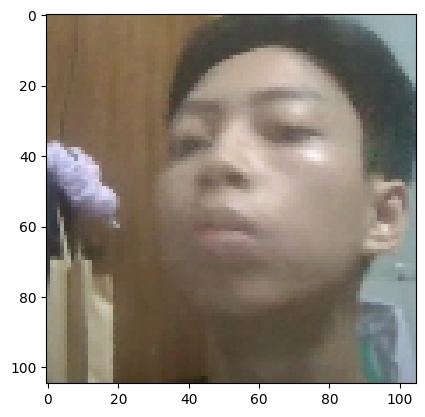

In [26]:
res = double_check(*try_img)
plt.imshow(res[1])

In [27]:
res[2]

np.float32(1.0)

In [28]:
#build pipline
data = data.map(double_check)
data = data.cache()
data = data.shuffle(buffer_size=2000)

In [29]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [21]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [31]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


## Model

In [32]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [33]:
embed = make_embedding()
embed.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding,validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [35]:
def make_siames_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))

    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer([embed(input_image), embed(validation_image)])

    classifier = Dense(1, activation ='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')


In [36]:
siamese_model = make_siames_model()

siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning


### Set up loss and optimize

In [37]:
binary_cross_loss = tf._losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [38]:
checkpoint_dir = './home/leloc/Documents/USTH-B3/Group_project/Model/trainning_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model =siamese_model)


In [39]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [40]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Tách batch thành đầu vào và nhãn
        X = batch[:2]
        y = batch[2]

        # Dự đoán đầu ra từ mô hình
        y_pred = siamese_model(X, training=True)

        # Tính toán mất mát
        loss = binary_cross_loss(y, y_pred)
        print(loss)

    # Tính gradient đối với các tham số có thể huấn luyện
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Áp dụng các gradient vào mô hình
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

        

In [41]:
from tensorflow.keras.metrics import Precision, Recall

In [42]:
def train(data, EPOCH):
    for epoch in range (1, EPOCH + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCH))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [43]:
EPOCH = 10

In [44]:
train(train_data, EPOCH)


 Epoch 1/10


/home/leloc/anaconda3/envs/facial_reg/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


I0000 00:00:1732010544.406832    8205 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732010549.585702    8208 service.cc:148] XLA service 0x7c42c3171fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732010549.594766    8208 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-19 17:02:29.660551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1732010551.699700    8208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/stept
1/

2024-11-19 17:03:00.234869: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/stept
1/1

2024-11-19 17:03:23.815618: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/stept
1/

2024-11-19 17:04:09.732224: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/stept
1/1

2024-11-19 17:05:39.438307: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/stept
1/1

In [45]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(test_input.shape)  # Phải là (1, 105, 105, 3)
print(test_val.shape)

(16, 105, 105, 3)
(16, 105, 105, 3)


In [33]:
import numpy as np
test_input = np.expand_dims(test_input, axis=0)  # Từ (105, 105, 3) -> (1, 105, 105, 3)
test_val = np.expand_dims(test_val, axis=0) 
print(test_input.shape)  # Phải là (1, 105, 105, 3)
print(test_val.shape)     # Từ (105, 105, 3) -> (1, 105, 105, 3)


(1, 105, 105, 3)
(1, 105, 105, 3)


In [46]:
y_hat = siamese_model.predict([test_input, test_val])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [47]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]

In [49]:
y_true

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [50]:
from tensorflow.keras.metrics import Recall, Precision

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
0.9864865 1.0


In [52]:
siamese_model.save('/home/leloc/Documents/USTH-B3/Group_project/Model/siamesemodel.h5')